In [49]:
%run "Models training helpers.ipynb" sort=False

Models training helpers.ipynb:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  "\n",


In [51]:
EXECUTE_EXAMPLE = False
if EXECUTE_EXAMPLE: #### JUST TO AVOID EXECUTING THIS CELL EVERY TIME

    NUM_SENTENCES_TO_SHOW=10
    #################################################
    ## Example of how to use the models helper files
    #################################################

    ## Read data
    training_df = read_training_data()

    ## This is done as example, test dataframe should be readed from a diferent file!
    test_df = training_df

    ## Tokenizer was already trained!
    assert(extended_tokenizer is not None)



    ## Train DL models

    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = train_DL_models(df_train,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=False) 

    ## Train ML models
    _MLModels = train_ML_models(df_train) 

    ##Getting sentences from data
    test_sentences = test_df['text'].values

    ## Calculate probability scores for for text data combining DL predictions and ML predictions
    mixture_preds = calculate_matches_mixture(test_sentences, _MLModels, _DLModels, _DLTokenizers)

    ## Getting top sentences per convention
    for conv in _MLModels.keys():
        print("\n\n     {}    \n\n".format(conv))
        for idx in test_sentences[mixture_preds[conv].argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
            print("{}\n".format(s))
            
            
    ## Store DL models in a pickle file
    store_DL_models_in_picke("test.pickle", _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories)
    
    ## Read DL models in a pickle file
    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = read_pickle("test.pickle")


Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------
Shape of data tensor: (709, 40)
Shape of label tensor: (709, 2)

Number of elements from each class in traing and validation set 
[ 74. 635.]
157


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 40, 100)      8603000     input_37[0][0]                   
__________________________________________________________________________________________________
conv1d_145 (Conv1D)             (None, 38, 128)      38528       embedding_37[0][0]               
__________________________________________________________________________________________________
conv1d_146 (Conv1D)             (None, 37, 128)      51328       embedding_37[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


-----------------------------------------------------
 >> Mixture model results
 >> Top sentences with higher confidence for Github:
            (Green convention)
-----------------------------------------------------

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfi

In [2]:
CONVENTION = "Green"
df = training_df[training_df['convention'] == CONVENTION]

In [3]:
## Checking performance setting validation data on the model training
## Validation data is created inside the models trainign function
conv_models = train_DL_models(df,
            data_class_column="convention", 
            data_label_column="label",
            df_val=None,
            tokenizer=extended_tokenizer,
            random_seed=0, 
            use_validation=True)

Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------
Shape of data tensor: (160, 40)
Shape of label tensor: (160, 2)

Number of elements from each class in traing and validation set 
[73. 55.]
[18. 14.]







model fitting - more complex convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 100)      8603000     input_1[0][0]                    
________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


Train on 128 samples, validate on 32 samples
Epoch 1/20
128/128 [==============================] - 0s 3ms/step - loss: 2.5304 - acc: 0.5234 - val_loss: 1.0818 - val_acc: 0.4375
Roc-AUC on validation: 0.5992
Epoch 2/20
128/128 [==============================] - 0s 344us/step - loss: 0.7381 - acc: 0.6016 - val_loss: 0.6217 - val_acc: 0.5625
Roc-AUC on validation: 0.7302
Epoch 3/20
128/128 [==============================] - 0s 382us/step - loss: 0.5756 - acc: 0.7812 - val_loss: 0.6409 - val_acc: 0.6875
Roc-AUC on validation: 0.7659
Epoch 4/20
128/128 [==============================] - 0s 368us/step - loss: 0.5953 - acc: 0.6562 - val_loss: 0.7216 - val_acc: 0.5625
Roc-AUC on validation: 0.7659
Epoch 5/20
128/128 [==============================] - 0s 374us/step - loss: 0.5094 - acc: 0.7813 - val_loss: 0.5556 - val_acc: 0.6875
Roc-AUC on validation: 0.8254
Epoch 6/20
128/128 [==============================] - 0s 377us/step - loss: 0.4387 - acc: 0.8516 - val_loss: 0.8944 - val_acc: 0.5625
Roc

In [4]:
## Checking performance setting validation data on the model training
## Validation data is created outside the models trainign function
## Training models
texts = df['text'].values
labels = df['label'].values

indices = np.arange(len(texts))
np.random.seed(0)
np.random.shuffle(indices)
texts = texts[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

x_train = texts[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = texts[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
df_train['text'] = x_train
df_train['label'] = y_train
df_train['convention'] = CONVENTION


df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
df_val['text'] = x_val
df_val['label'] = y_val
df_val['convention'] = CONVENTION

print("\n\n===========================")
print("WITH VALIDATION!")
print("===========================\n\n")
models2 = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0, use_validation=True)




WITH VALIDATION!


Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------

Number of elements from each class in traing and validation set 
[73. 55.]
[18. 14.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 100)      8603000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 38, 128)      38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 37, 128)      51328       embedding_2[0][0]                
__________________________________

In [5]:
######################
### Cross validation
######################

## 1. Split training, validation data outside the training function
## 2. Train a model with training data
## 3. Check performance (acc) of the model on training and validation
## 4. Repeat num_tests times
## Next cell plots results

## Number of tests = 10
num_tests = 10
num_epochs = 20

accs = []
val_accs = []
epochs = np.arange(0,num_epochs, 1)

texts = df['text'].values
labels = df['label'].values


for n in range(num_tests):
    print("\n\n=================================")
    print("               {}".format(n))
    print("=================================")
    indices = np.arange(len(texts))
    np.random.shuffle(indices)
    texts = texts[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

    x_train = texts[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = texts[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_train['text'] = x_train
    df_train['label'] = y_train
    df_train['convention'] = CONVENTION


    df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_val['text'] = x_val
    df_val['label'] = y_val
    df_val['convention'] = CONVENTION


    tmp_training = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0,
                use_validation=True, 
                num_epochs = num_epochs)

    accs.append(tmp_training[4][CONVENTION].history['acc'])
    val_accs.append(tmp_training[4][CONVENTION].history['val_acc'])       




               0
Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------

Number of elements from each class in traing and validation set 
[73. 55.]
[18. 14.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 100)      8603000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 38, 128)      38528       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 37, 128)      51328       embedding_3[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 100)      8603000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 38, 128)      38528       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 37, 128)      51328       embedding_4[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 100)      8603000     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 38, 128)      38528       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 37, 128)      51328       embedding_5[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 100)      8603000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 38, 128)      38528       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 37, 128)      51328       embedding_6[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 40, 100)      8603000     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 38, 128)      38528       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 37, 128)      51328       embedding_7[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 40, 100)      8603000     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 38, 128)      38528       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 37, 128)      51328       embedding_8[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 40, 100)      8603000     input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 38, 128)      38528       embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 37, 128)      51328       embedding_9[0][0]                
__________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 40, 100)      8603000     input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 38, 128)      38528       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 37, 128)      51328       embedding_10[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 40, 100)      8603000     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 38, 128)      38528       embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 37, 128)      51328       embedding_11[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 100)      8603000     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 38, 128)      38528       embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 37, 128)      51328       embedding_12[0][0]               
_________________________________

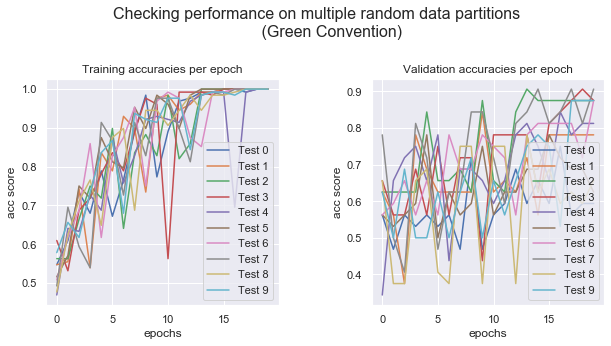

In [6]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Checking performance on multiple random data partitions\n       ({} Convention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


for i in range(len(accs)):
    plt.plot(epochs,accs[i], label="Test {}".format(i))
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)
for i in range(len(val_accs)):
    plt.plot(epochs,val_accs[i], label="Test {}".format(i))
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()

In [7]:
models2_tokenizer = models2[1][CONVENTION]
val_seq = models2_tokenizer.texts_to_sequences(x_val)
val_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds2 = models2[0][CONVENTION].predict(val_seq)
print("Real label for samples classified with value 0")
display(y_val[preds2[:,0]>preds2[:,1]])
print("Real label for samples classified with value 1")
display(y_val[preds2[:,0]<preds2[:,1]])

Real label for samples classified with value 0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Real label for samples classified with value 1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:

print("\n\n===========================")    
print("WITHOUT VALIDATION!")
print("===========================\n\n")
models3 = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=None,
                tokenizer = models2_tokenizer,
                random_seed=0, use_validation=False)




WITHOUT VALIDATION!


Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------
Shape of data tensor: (128, 40)
Shape of label tensor: (128, 2)

Number of elements from each class in traing and validation set 
[75. 53.]
16


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 40, 100)      8603000     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 38, 128)      38528       embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 37, 128)      51328       embedding_13[0][0]               
_________________________________

In [9]:

val_seq = models2_tokenizer.texts_to_sequences(x_val)
val_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds2 = models2[0][CONVENTION].predict(val_seq)
print("Real label for samples classified with value 0")
display(y_val[preds2[:,0]>preds2[:,1]])
print("Real label for samples classified with value 1")
display(y_val[preds2[:,0]<preds2[:,1]])

Real label for samples classified with value 0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Real label for samples classified with value 1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:

tok1 = create_tokenizer(training_df)
word_index = tok1.word_index
tok1_words = []
for word, i in word_index.items():
    tok1_words.append(word)

for idx, _df in enumerate(gathered_dfs[:-1]):
    tok2 = create_tokenizer(_df)
    word_index2 = tok2.word_index

    gathered_f = gathered_data_files[idx]

    tok2_words = []
    for word, i in word_index2.items():
        tok2_words.append(word)

    words_in_tok1 = [w for w in tok2_words if w in tok1_words]
    tok1_words_in_tok2 = [w for w in tok1_words if w in tok2_words]
    print("\n > {}".format(gathered_f))
    print("Gathered source words in training data: {}".format(len(words_in_tok1) / len(tok1_words)))
    print("Training data words in gathered source: {}".format(len(tok1_words_in_tok2) / len(tok2_words)))



 > gathered_green_test.tsv
Gathered source words in training data: 0.17887261429205503
Training data words in gathered source: 0.676552881925014

 > gathered_s2_17-19_ki.tsv
Gathered source words in training data: 0.6542387927208166
Training data words in gathered source: 0.22616612111292964

 > gathered_news_sentences.tsv
Gathered source words in training data: 0.5607338363663263
Training data words in gathered source: 0.23240127544763306

 > _gathered_github_sentences.tsv
Gathered source words in training data: 0.6028998372540316
Training data words in gathered source: 0.1381871206212486

 > gathered_github_sentences.tsv
Gathered source words in training data: 0.7458203876313064
Training data words in gathered source: 0.07416507282624688

 > gathered_s2_17-19_ki_kw.tsv
Gathered source words in training data: 0.6045272969374168
Training data words in gathered source: 0.29317643682284567


In [11]:

NUM_SENTENCES_TO_SHOW=10

df_test = pd.read_csv(os.path.join(GATHERED_DATA_FOLDER, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    
    

-----------------------------------------------------
 >> Top sentences with higher confidence for Github:
            (Green convention)
-----------------------------------------------------

instabug offering awesome-ios community an exclusive 15 discount on all paid plans.get started how to useawesome-ios is an amazing list for people who need a certain feature on their app, so the best ways to use it are - ask for help on our twitter or gitter channel- simply press command f to search for a keyword- go through our content menu content- about- how to use- courses- accessibility- alexa- analytics- app routing- apple tv- architecture patterns- arkit- authentication- blockchain- bridging- cache- charts- code quality - linter- color- command line- concurrency- core data- database- data structures algorithms- date time- debugging- eventbus- files- functional programming- games- gcd- gesture- graphics- hardware - bluetooth - camera - force touch - ibeacon - location - other hardware- layo

In [34]:
### Ading more green examples
green_audit_df = pd.read_csv("Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL_2019-10-08-20:23:58.598102.tsv", sep="\t")
green_audit_df = green_audit_df[['text', 'provenance', 'convention', 'new']]
green_audit_df = green_audit_df.rename(columns={"new": "label"})
green_audit_df = green_audit_df[green_audit_df['convention']=='green']
green_audit_df['convention'] = "Green"
green_audit_df.head(5)



,text,provenance,convention,label
10,Integrated web-based platform that manages the...,efficiency,Green,1
57,A ptracing profiler For Python.,efficiency,Green,0
64,"System load: 0.39 ,Memory usage: 2%, Processes...",efficiency,Green,0
81,New EPA Rules Will Aim To Cut Methane Emission...,HuffPost_News,Green,1
82,Dawn The Fox Wags Her Tail (VIDEO)Disclaimer: ...,HuffPost_News,Green,1


In [35]:
green_df = pd.concat([df, green_audit_df])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [36]:
######################
### Cross validation with new data
######################

## 1. Split training, validation data outside the training function
## 2. Train a model with training data
## 3. Check performance (acc) of the model on training and validation
## 4. Repeat num_tests times
## Next cell plots results

## Number of tests = 10
num_tests = 10
num_epochs = 20

accs2 = []
val_accs2 = []
epochs = np.arange(0,num_epochs, 1)

texts = green_df['text'].values
labels = green_df['label'].values
np.random.seed(0)

for n in range(num_tests):
    print("\n\n=================================")
    print("               {}".format(n))
    print("=================================")
    indices = np.arange(len(texts))

    np.random.shuffle(indices)
    texts = texts[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

    x_train = texts[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = texts[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_train['text'] = x_train
    df_train['label'] = y_train
    df_train['convention'] = CONVENTION


    df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_val['text'] = x_val
    df_val['label'] = y_val
    df_val['convention'] = CONVENTION


    tmp_training = train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0,
                use_validation=True, 
                num_epochs = num_epochs)

    accs2.append(tmp_training[4][CONVENTION].history['acc'])
    val_accs2.append(tmp_training[4][CONVENTION].history['val_acc'])       




               0
Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------

Number of elements from each class in traing and validation set 
[ 74. 635.]
[ 20. 157.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 40, 100)      8603000     input_25[0][0]                   
__________________________________________________________________________________________________
conv1d_97 (Conv1D)              (None, 38, 128)      38528       embedding_25[0][0]               
__________________________________________________________________________________________________
conv1d_98 (Conv1D)              (None, 37, 128)      51328       embedding_25[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 40, 100)      8603000     input_26[0][0]                   
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 38, 128)      38528       embedding_26[0][0]               
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, 37, 128)      51328       embedding_26[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 40, 100)      8603000     input_27[0][0]                   
__________________________________________________________________________________________________
conv1d_105 (Conv1D)             (None, 38, 128)      38528       embedding_27[0][0]               
__________________________________________________________________________________________________
conv1d_106 (Conv1D)             (None, 37, 128)      51328       embedding_27[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 40, 100)      8603000     input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 38, 128)      38528       embedding_28[0][0]               
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 37, 128)      51328       embedding_28[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 40, 100)      8603000     input_29[0][0]                   
__________________________________________________________________________________________________
conv1d_113 (Conv1D)             (None, 38, 128)      38528       embedding_29[0][0]               
__________________________________________________________________________________________________
conv1d_114 (Conv1D)             (None, 37, 128)      51328       embedding_29[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 40, 100)      8603000     input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 38, 128)      38528       embedding_30[0][0]               
__________________________________________________________________________________________________
conv1d_118 (Conv1D)             (None, 37, 128)      51328       embedding_30[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 40, 100)      8603000     input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_121 (Conv1D)             (None, 38, 128)      38528       embedding_31[0][0]               
__________________________________________________________________________________________________
conv1d_122 (Conv1D)             (None, 37, 128)      51328       embedding_31[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 40, 100)      8603000     input_32[0][0]                   
__________________________________________________________________________________________________
conv1d_125 (Conv1D)             (None, 38, 128)      38528       embedding_32[0][0]               
__________________________________________________________________________________________________
conv1d_126 (Conv1D)             (None, 37, 128)      51328       embedding_32[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 40, 100)      8603000     input_33[0][0]                   
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 38, 128)      38528       embedding_33[0][0]               
__________________________________________________________________________________________________
conv1d_130 (Conv1D)             (None, 37, 128)      51328       embedding_33[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 40, 100)      8603000     input_34[0][0]                   
__________________________________________________________________________________________________
conv1d_133 (Conv1D)             (None, 38, 128)      38528       embedding_34[0][0]               
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, 37, 128)      51328       embedding_34[0][0]               
_________________________________

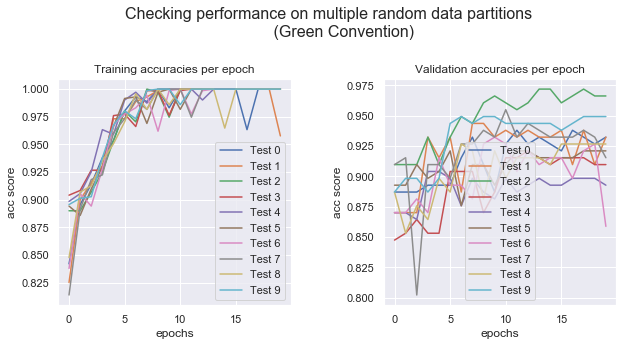

In [37]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Checking performance on multiple random data partitions\n       ({} Convention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


for i in range(len(accs)):
    plt.plot(epochs,accs2[i], label="Test {}".format(i))
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)
for i in range(len(val_accs)):
    plt.plot(epochs,val_accs2[i], label="Test {}".format(i))
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()

In [38]:
## Checking performance setting validation data on the model training
## Validation data is created inside the models trainign function
conv_models2 = train_DL_models(green_df,
            data_class_column="convention", 
            data_label_column="label",
            df_val=None,
            tokenizer=extended_tokenizer,
            random_seed=0, 
            use_validation=True)

Found 86029 unique tokens.
----------------------------------------------------------------
            Green                  
----------------------------------------------------------------
Shape of data tensor: (886, 40)
Shape of label tensor: (886, 2)

Number of elements from each class in traing and validation set 
[ 74. 635.]
[ 20. 157.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 40, 100)      8603000     input_35[0][0]                   
__________________________________________________________________________________________________
conv1d_137 (Conv1D)             (None, 38, 128)      38528       embedding_35[0][0]               
__________________________________________________________________________________________________
conv1d_138 (Conv1D)             (None, 37, 128)      51328       embedding_35[0][0]               
_________________________________

In [39]:


NUM_SENTENCES_TO_SHOW=20

df_test = pd.read_csv(os.path.join(GATHERED_DATA_FOLDER, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values
test_sentences = np.array([sent for sent in test_sentences if len(sent.split(" "))<40])

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models2[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> DL model results")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    

-----------------------------------------------------
 >> DL model results
 >> Top sentences with higher confidence for Github:
            (Green convention)
-----------------------------------------------------

rxcoredata - rxswift extensions for core data rxautomaton - rxswift state machine, inspired by redux and elm.

b abouta curated list of awesome ios frameworks, libraries, tutorials, xcode extensions and plugins, components and much more.the list is divided into categories such as frameworks, components, testing and others, open source projects, free and paid services.

coinpaprikaapi - coinpaprika api client with free frequently updated market data from the world of crypto coin prices, volumes, market caps, aths, return rates and more.

facecropper - crop faces, inside of your image, with ios 11 vision api paparazzo - custom ios camera and photo picker with editing capabilities zimagecropper - a swift project to crop image in any shape.

watchdog - class for logging excessive

In [40]:
_DLModels = conv_models2[0]
_DLTokenizers = conv_models2[1]

In [42]:
_MLModels = train_ML_models(green_df)

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [48]:
test_sentences = df_test['sentence'].values

mixture_preds = calculate_matches_mixture(test_sentences, _MLModels, _DLModels, _DLTokenizers)


print("-----------------------------------------------------")
print(" >> Mixture model results")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for idx in test_sentences[mixture_preds[CONVENTION].argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    

    

-----------------------------------------------------
 >> Mixture model results
 >> Top sentences with higher confidence for Github:
            (Green convention)
-----------------------------------------------------

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfig - an xcconfig xcode configuration file for easily turning on a boatload of warnings in your project or its targets.

buglife - awesome bug reporting for ios apps warnings-xcconfi

In [ ]:
df['te']